In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import re
import time
import json
from src.data_analysis import web_utilities
from src.data_analysis import df_utilities
%matplotlib inline 

### Problem Overview

As Star Wars data nerds, we have a few questions about the Universe. We don’t really like wikis, but we do
love APIs, code, charts, and graphs!

We’ve seen the Star Wars API (https://swapi.co), and its data seem useful. However, it leaves us with a few
specific questions that we need answered in visual form:
    1. It seems like there is quite a variety of heights in the Star Wars Universe. Show us the distribution 
    of heights across gender, homeworld, and species.
    2. The Original Trilogy and the Prequel Trilogy both featured men in leading roles and women in supporting 
    roles, but the Sequel Trilogy features a leading woman. What is the distribution of genders across the films?
    3. Back to our difficult-to-explain interest in heights: can you find and visualize a linear regression that
    clearly explains the height of an individual? Using a programming language and/or framework of your choice, 
    write a program that gives us insight into these questions. We like visualizations (e.g. charts and graphs), 
    not tables or lists of numbers. If you have any other ideas, questions or insights from the data, we’d love 
    to see those as well!

## Navigating the API

There are a few different ways to access the API. The resource types are:
 - Film, People, Planets, Species, Starships, and Vehicles

Film will give us information about each film (title, opening crawl, director, etc.), people will give us information about a person within the Star Wars universe (name, height, eye color, etc.), and so on. Here it makes sense to focus on the "people" resource - since we're being asked very "people-centric" questions. 

In [2]:
url = 'http://swapi.co/api/people/'
a = web_utilities.get_json(url)

Visiting url: http://swapi.co/api/people/


In [3]:
a.keys()

dict_keys(['count', 'next', 'previous', 'results'])

In [4]:
print('Next: {}'.format(a['next']), 
      'Previous: {}'.format(a['previous']), 
      'Count: {}'.format(a['count']), sep='\n')

Next: https://swapi.co/api/people/?page=2
Previous: None
Count: 87


In [5]:
a['results']

[{'name': 'Luke Skywalker',
  'height': '172',
  'mass': '77',
  'hair_color': 'blond',
  'skin_color': 'fair',
  'eye_color': 'blue',
  'birth_year': '19BBY',
  'gender': 'male',
  'homeworld': 'https://swapi.co/api/planets/1/',
  'films': ['https://swapi.co/api/films/2/',
   'https://swapi.co/api/films/6/',
   'https://swapi.co/api/films/3/',
   'https://swapi.co/api/films/1/',
   'https://swapi.co/api/films/7/'],
  'species': ['https://swapi.co/api/species/1/'],
  'vehicles': ['https://swapi.co/api/vehicles/14/',
   'https://swapi.co/api/vehicles/30/'],
  'starships': ['https://swapi.co/api/starships/12/',
   'https://swapi.co/api/starships/22/'],
  'created': '2014-12-09T13:50:51.644000Z',
  'edited': '2014-12-20T21:17:56.891000Z',
  'url': 'https://swapi.co/api/people/1/'},
 {'name': 'C-3PO',
  'height': '167',
  'mass': '75',
  'hair_color': 'n/a',
  'skin_color': 'gold',
  'eye_color': 'yellow',
  'birth_year': '112BBY',
  'gender': 'n/a',
  'homeworld': 'https://swapi.co/api/pl

This is a very nice API. By making a GET request to the root "people" url, we are given all the information we need to request all of the "people" resources.

# People Attributes
![people_attribute info](./assets/images/people_attributes.png)

There are 87 people, so we can easily load all of the People data into memory. It would be nice to put these into a Pandas DataFrame, but the data will need to be wrangled a little bit first. We can drop "url", "created", and "edited". The "films", "species", "starships", and "vehicles" attributes are returned arrays, so we'll need to figure out some way to make these into valid columns. For "films" for example, we might have a column for each movie and a value of True or False for each row, indicating if the person was present or not. 

In [6]:
column_list = ['name','birth_year','eye_color','gender','hair_color',
                'height','mass','skin_color','homeworld']

In [7]:
#from src.data_analysis import web_utilities
from src.data_analysis import df_utilities

In [8]:
# results = a['results']
# df = df_utilities.get_initial_df()
# df = df_utilities.add_to_df(df, results)

In [9]:
# df[df.columns[:12]].head()

## Writing data to csv
This takes a little while to run (because I added a delay to be courteous). I'm writing the data to a csv on my machine so that I don't have to reload it from the site over and over.

In [10]:
if not os.path.exists('./assets/dataframe.csv'):
    df = df_utilities.build_dataframe()
    df = df_utilities.cleanup(df)
    df.to_csv('./assets/dataframe.csv')
else: 
    df = pd.read_csv('./assets/dataframe.csv', index_col = 0)
    print("Dataframe loaded from .csv!")

Dataframe loaded from .csv!


In [11]:
df.head()

,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
0,Luke Skywalker,-19.0,blue,male,blond,172.0,77,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,-112.0,yellow,no gender,no hair,167.0,75,gold,Tatooine,Droid,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,-33.0,red,no gender,no hair,96.0,32,"white, blue",Naboo,Droid,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,-41.9,yellow,male,none,202.0,136,white,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,-19.0,brown,female,brown,150.0,49,light,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False


Part of what makes Pandas fast is the fact that under the hood it's making use of Numpy ndarrays. These have to be a single datatype though (bool, int, float, etc.), so if we have an array that's all integers and one string, the whole thing will be cast to Numpy's "fallback" datatype, which is "object". We want to avoid that because working with an object ndarray is pretty slow by comparison.

(OK - I'll admit, it doesn't really matter much here. Just pointing it out to look cool)

In [12]:
df.head()

,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
0,Luke Skywalker,-19.0,blue,male,blond,172.0,77,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,-112.0,yellow,no gender,no hair,167.0,75,gold,Tatooine,Droid,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,-33.0,red,no gender,no hair,96.0,32,"white, blue",Naboo,Droid,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,-41.9,yellow,male,none,202.0,136,white,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,-19.0,brown,female,brown,150.0,49,light,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False


![birth year info](./assets/images/birth_year.png)

In [13]:
# ## The birth years are in either "BBY" or "ABY", before or after an event in the 
# ## Star Wars universe. We can cast BBY values as negative floats, ABY values as positive
# ## floats, and "unknown" as NaN
# def do_stuff(x):
#     if x[-3:] == 'BBY': return -float(x[:-3])
#     elif x[-3:] == 'ABY': return float(x[:-3])
#     else: return np.NaN
    
# def format_birth_year(df):
#     return df.birth_year.apply(lambda x: do_stuff(x))

# print(np.where(format_birth_year(df) > 0)[0])
# # Hmm, they never use any ABY dates. I guess they're leaving the door open for 
# # future information to be added (with new movies and all)

# Data Visualization

The data is now in a Pandas Dataframe. This gives us a lot of useful tools. We can take advantage of some of the things that make Numpy powerful (vectorization, broadcasting, etc), while gaining a lot of convenience (labeled columns, easier to deal with missing values, etc.). 

In [14]:
def num_known(df, x):
    return np.where(df[x] != 'unknown')[0].shape[0]
def num_unknown(df, x):
    return np.where(df[x] == 'unknown')[0].shape[0]

## Unknown values
Let's get an idea of how much of our data is unknown. 

In [15]:
for i in df.columns[1:9]:
    u = num_unknown(df, i)
    print('Field: {}\t\t{} out of 87 are unknown'.format(i.ljust(10), u))

Field: birth_year		0 out of 87 are unknown
Field: eye_color 		3 out of 87 are unknown
Field: gender    		0 out of 87 are unknown
Field: hair_color		1 out of 87 are unknown
Field: height    		0 out of 87 are unknown
Field: mass      		0 out of 87 are unknown
Field: skin_color		0 out of 87 are unknown
Field: homeworld 		10 out of 87 are unknown


/Users/tc/anaconda3/envs/hensel_phelps/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


So it might be iffy to make conclusions using the birth_year or mass fields.

## Height distribution across gender

In [16]:
# a['results']

In [17]:
def format_col_entry(x,i,j,w):
    a = '{}'.format(i).ljust(w-5)[:w-5]
    b = '{}: {}'.format('counts',j).ljust(w-5)[:w-5]
    return a+' '*5+b

def print_header(x, w, cols):
    a = '{}'.format(x.ljust(w-5))[:w-5]
    b = '{}'.format('counts'.ljust(w-5))[:w-5]
    print(*[a+' '*5+b for i in range(cols)] , sep='    |', end='\n')
    print('-'*72) 

def get_unique_counts(df,x,sort=False):
    non_na_ind = ~df[x].isna()
    if not sort:
        return np.unique(df[x][non_na_ind], return_counts=True)
    else:
        u, c = np.unique(df[x][non_na_ind], return_counts=True)
        inx = np.argsort(c)
        return u[inx][::-1], c[inx][::-1]
    
def print_unique_counts(df,x,w=25,cols=2): #
    print_header(x,w,cols)
    x_vals, x_counts = get_unique_counts(df, x, sort=True)
    l = [format_col_entry(x,i,j,w) for i,j in zip(x_vals, x_counts)]
    r = len(l)%cols
    if r != 0:
        l += [format_col_entry(x,'NaN',sum(df[x].isna()),w)]
    c = len(l)//cols
    col_list = [l[i:i+c] for i in range(0,len(l),c)]
    
    for i in range(c):
        print(*[col_list[j][i] for j in range(cols)], sep='    |', end='\n')
    if r == 0:
        print(format_col_entry(x,'NaN',sum(df[x].isna()),w))

print_unique_counts(df, 'gender')

gender                   counts                  |gender                   counts              
------------------------------------------------------------------------
male                     counts: 62              |none                     counts: 2           
female                   counts: 19              |hermaphrodite            counts: 1           
no gender                counts: 3               |NaN                      counts: 0           


It makes sense to ignore the hermaphrodite, n/a, and none values

In [18]:
def get_height_mask(df, g):
    return df.apply(lambda x: True if ((x.gender == g) and \
                    (x.height != 'unknown')) else False, axis = 1)
    
male_heights = df.height[get_height_mask(df, 'male')]
female_heights = df.height[get_height_mask(df, 'female')]
# male_mask = np.where(df.gender == 'male')[0]
# female_mask = np.where(df.gender == 'female')[0]
# male_heights = df.height[male_mask]
# female_heights = df.height[female_mask]

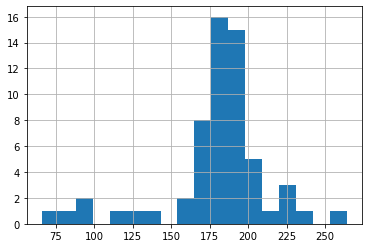

In [19]:
male_heights.hist(bins = 18)

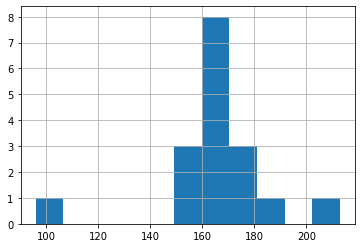

In [20]:
female_heights.hist(bins = 11)

In [21]:
## Wow, that's really not many women. I didn't realize there were so few
np.where(df.gender=='female')[0].shape[0]

19

In [22]:
df = df_utilities.cleanup(df)
df.head()

planets JSON loaded!
films JSON loaded!
species JSON loaded!
vehicles JSON loaded!
starships JSON loaded!
planets JSON loaded!
films JSON loaded!
species JSON loaded!
vehicles JSON loaded!
starships JSON loaded!
planets JSON loaded!
films JSON loaded!
species JSON loaded!
vehicles JSON loaded!
starships JSON loaded!


,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
0,Luke Skywalker,-19.0,blue,male,blond,172.0,77,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,-112.0,yellow,no gender,no hair,167.0,75,gold,Tatooine,Droid,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,-33.0,red,no gender,no hair,96.0,32,"white, blue",Naboo,Droid,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,-41.9,yellow,male,none,202.0,136,white,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,-19.0,brown,female,brown,150.0,49,light,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False


In [23]:
for i in np.arange(9,15,1):
    print(df.columns[i])


species
The Empire Strikes Back
Revenge of the Sith
Return of the Jedi
A New Hope
The Force Awakens


In [24]:
df.tail(30)

,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
57,Cordé,NaN,brown,female,brown,157.0,NaN,light,Naboo,Human,...,False,False,False,False,False,False,False,False,False,False
58,Cliegg Lars,-82.0,blue,male,brown,183.0,NaN,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
59,Poggle the Lesser,NaN,yellow,male,none,183.0,80,green,Geonosis,Geonosian,...,False,False,False,False,False,False,False,False,False,False
60,Luminara Unduli,-58.0,blue,female,black,170.0,56.2,yellow,Mirial,Mirialan,...,False,False,False,False,False,False,False,False,False,False
61,Barriss Offee,-40.0,blue,female,black,166.0,50,yellow,Mirial,Mirialan,...,False,False,False,False,False,False,False,False,False,False
62,Dormé,NaN,brown,female,brown,165.0,NaN,light,Naboo,Human,...,False,False,False,False,False,False,False,False,False,False
63,Dooku,-102.0,brown,male,white,193.0,80,fair,Serenno,Human,...,False,False,False,False,False,True,False,False,False,False
64,Bail Prestor Organa,-67.0,brown,male,black,191.0,NaN,tan,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False
65,Jango Fett,-66.0,brown,male,black,183.0,79,tan,Concord Dawn,Human,...,False,False,False,False,False,False,False,False,False,False
66,Zam Wesell,NaN,yellow,female,blonde,168.0,55,"fair, green, yellow",Zolan,Clawdite,...,False,False,False,False,False,False,True,False,False,False


In [25]:
df.head()

,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
0,Luke Skywalker,-19.0,blue,male,blond,172.0,77,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,-112.0,yellow,no gender,no hair,167.0,75,gold,Tatooine,Droid,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,-33.0,red,no gender,no hair,96.0,32,"white, blue",Naboo,Droid,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,-41.9,yellow,male,none,202.0,136,white,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,-19.0,brown,female,brown,150.0,49,light,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False


In [26]:
df_utilities.urls_to_names(df).head()

planets JSON loaded!
films JSON loaded!
species JSON loaded!
vehicles JSON loaded!
starships JSON loaded!


,name,birth_year,eye_color,gender,hair_color,height,mass,skin_color,homeworld,species,...,Slave 1,A-wing,Naboo Royal Starship,Scimitar,Sith speeder,Flitknot speeder,Koro-2 Exodrive airspeeder,Tsmeu-6 personal wheel bike,T-70 X-wing fighter,H-type Nubian yacht
0,Luke Skywalker,-19.0,blue,male,blond,172.0,77,fair,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
1,C-3PO,-112.0,yellow,no gender,no hair,167.0,75,gold,Tatooine,Droid,...,False,False,False,False,False,False,False,False,False,False
2,R2-D2,-33.0,red,no gender,no hair,96.0,32,"white, blue",Naboo,Droid,...,False,False,False,False,False,False,False,False,False,False
3,Darth Vader,-41.9,yellow,male,none,202.0,136,white,Tatooine,Human,...,False,False,False,False,False,False,False,False,False,False
4,Leia Organa,-19.0,brown,female,brown,150.0,49,light,Alderaan,Human,...,False,False,False,False,False,False,False,False,False,False


In [27]:
# Wow, everyone has to be SO special with their homeworlds.
print_unique_counts(df,'homeworld')

homeworld                counts                  |homeworld                counts              
------------------------------------------------------------------------
Naboo                    counts: 11              |Champala                 counts: 1           
unknown                  counts: 10              |Cerea                    counts: 1           
Tatooine                 counts: 10              |Iktotch                  counts: 1           
Coruscant                counts: 3               |Troiken                  counts: 1           
Kamino                   counts: 3               |Kalee                    counts: 1           
Alderaan                 counts: 3               |Trandosha                counts: 1           
Mirial                   counts: 2               |Toydaria                 counts: 1           
Ryloth                   counts: 2               |Tund                     counts: 1           
Kashyyyk                 counts: 2               |Sullust      

In [28]:
worlds,world_counts = np.unique(df.homeworld, return_counts=True)
populous_worlds = worlds[np.where(world_counts>2)]
populous_worlds

array(['Alderaan', 'Coruscant', 'Kamino', 'Naboo', 'Tatooine', 'unknown'],
      dtype=object)

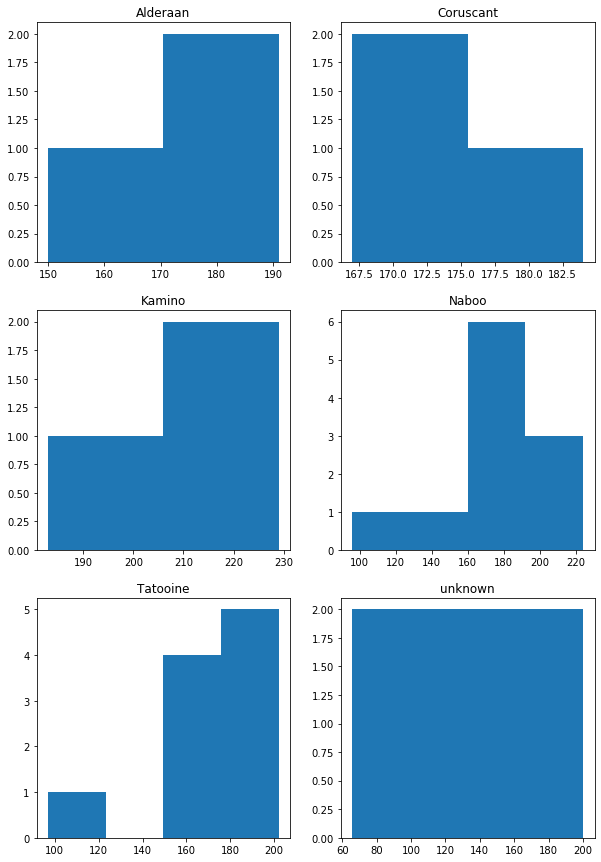

In [29]:
def union_not_nan_mask(df, col1, col2, val):
    if val.lower()[:3] in {'any', 'all'}:
        uindex = [True if not (pd.isna(df.loc[i][col1]) or pd.isna(df.loc[i][col2])) 
                  else False for i in range(df.shape[0])]
        return uindex
    else:
        return df.apply(lambda x: True if ((x[col1] == val)\
                        and (x[col2] != 'unknown')\
                        and not (pd.isna(x[col2])))\
                        else False, axis = 1)

fig = plt.figure(figsize=(10,15))
ax_list = []
hmax = 0
hmin = 500
height_list = []
for i in range(len(populous_worlds)):
    world = populous_worlds[i]
    windex = union_not_nan_mask(df, 'homeworld','height', world)
    height_list.append(list(df.height[windex]))
    for j in df.height[windex]:
        n = int(j)
        if n > hmax: hmax = n
        if n < hmin: hmin = n
            
for h, w, i in zip(height_list, populous_worlds, range(len(populous_worlds))):
    hbins = np.array([hmin]+[int(j) for j in h]+[hmax])
    ax_list.append(fig.add_subplot(3,2,i+1))
    #ax_list[-1].set_xlim([60,230])
    ax_list[-1].hist(h, bins='sqrt', histtype='stepfilled')
    ax_list[-1].set_title(populous_worlds[i])


# for i in range(len(populous_worlds)):
#     world = populous_worlds[i]
#     windex = get_height_mask(df, 'homeworld','height', world)
#     ax = fig.add_subplot(3,2,i+1)
#     ax.hist(df.height[windex])
#     ax.set_title(populous_worlds[i])
#     height_list.append(list(df.height[windex]))
#     for j in df.height[windex]:
#         n = int(j)
#         if n > hmax: hmax = n
#         if n < hmin: hmin = n

In [30]:
for h,w in zip(height_list, populous_worlds):
    print(w)
    print(h)

Alderaan
[150.0, 191.0, 188.0]
Coruscant
[170.0, 184.0, 167.0]
Kamino
[183.0, 229.0, 213.0]
Naboo
[96.0, 170.0, 196.0, 224.0, 206.0, 183.0, 183.0, 185.0, 157.0, 165.0, 165.0]
Tatooine
[172.0, 167.0, 202.0, 178.0, 165.0, 97.0, 183.0, 188.0, 163.0, 183.0]
unknown
[66.0, 200.0, 193.0, 96.0]


In [31]:
print_unique_counts(df,'species')

species                  counts                  |species                  counts              
------------------------------------------------------------------------
Human                    counts: 35              |Ewok                     counts: 1           
unknown                  counts: 5               |Muun                     counts: 1           
Droid                    counts: 5               |Mon Calamari             counts: 1           
Gungan                   counts: 3               |Togruta                  counts: 1           
Kaminoan                 counts: 2               |Yoda's species           counts: 1           
Mirialan                 counts: 2               |Xexto                    counts: 1           
Zabrak                   counts: 2               |Vulptereen               counts: 1           
Twi'lek                  counts: 2               |Trandoshan               counts: 1           
Wookiee                  counts: 2               |Toydarian    

In [32]:
species,species_count = get_unique_counts(df,'species')
common_species = species[np.where(species_count>2)][:-1]
common_species
# species, species_count

array(['Droid', 'Gungan', 'Human'], dtype=object)

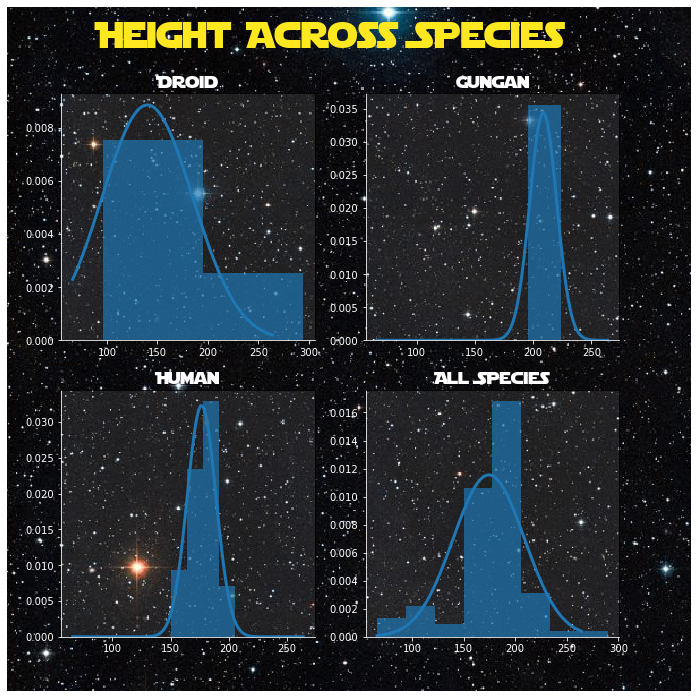

In [33]:
from astropy.visualization import hist
import matplotlib
from PIL import Image
from matplotlib import font_manager as fm
from src.graphing import star_graph

def match_hist_color(fig):
    p_list = [i for i in fig.axes[-1].get_children() 
         if type(i) == matplotlib.patches.Polygon]
    return p_list[-1].get_facecolor()

def get_scaled_img(fig):
    fig_size = fig.get_size_inches()*fig.dpi 
    img = Image.open('assets/images/starfield.png')
    img_size = img.size
    a = [i - j for i,j in zip(fig_size, img_size)]
    b = [0,0]
    small_axis = np.argmax(a)
    crop_axis = np.argmin(a)
    b[small_axis] = img_size[small_axis] 
    crop_size = int((img_size[small_axis]/fig_size[small_axis])*fig_size[crop_axis])
    b[crop_axis] = crop_size
    box = (0, 0, b[0], b[1])
    img = img.resize((int(fig_size[0]),int(fig_size[1])),box=box)
    return img
    
def axis_style(ax,title,legend=False,alpha=.1):
    fpath = './assets/fonts/starjedi/Starjedi.ttf'
    prop = fm.FontProperties(fname=fpath)
    ax.patch.set_facecolor((1, 1, 1, alpha))
    #ax.patch.set_edgecolor(edge_color)
    ax.patch.set_linewidth(2)
    ax.tick_params(axis='both', colors='white')
    ax.set_title(title, fontproperties=prop, color='white', size='xx-large')
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')
    if legend:
        prop = fm.FontProperties(fname=fpath,size=22)
        plt.legend(loc='upper right',prop=prop, bbox_to_anchor=[1,.95]) 
    return ax
    
def make_it_cool(fig, col_vals, bbox, main_title,mt_size):
    fpath = './assets/fonts/stjelogo/Stjldbl2.ttf'
    prop = fm.FontProperties(fname=fpath)
    fig.get_children()[1].axis("off")
    fig.get_children()[1].set_position(bbox)
    if len(fig.get_children()) > 3:
        for i, title in zip(fig.get_children()[2:], col_vals):
            i = axis_style(i,title)
    else:
        pass
    fig.suptitle(main_title,fontproperties=prop, 
                 color='#FFE81F', fontsize=mt_size)

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    return ax
    
def plot_single_axis(quant_list, col1_vals, graph_width, hmin, hmax, 
                     bin_val, htype):
    clen = len(col1_vals)
    fig, ay = plt.subplots(figsize=(graph_width,graph_width))
    img = get_scaled_img(fig)
    ay.imshow(img)
    ax = fig.add_subplot(111)
    for v1, v2, i in zip(quant_list, col1_vals, range(clen)):
        n, bins, patches = hist(v1, bins=bin_val, histtype=htype, alpha=0.7, 
                                density=True, label=col1_vals[i], zorder=10+i)
        mu, std = norm.fit(v1)
        x = np.linspace(hmin,hmax,100)
        y = norm.pdf(x, mu, std)
        c = match_hist_color(fig)
        l = ax.plot(x, y, color=c, linewidth=2,alpha=1, zorder=15+i) 
        ax = axis_style(ax,"",legend=True, alpha=0)
        ax.tick_params('both',labelsize=16)
    return fig, ax, patches

def plot_df_hist(df, col1, col1_vals, col2='height', graph_width=10,
                    plot_type='cols', bin_val='freedman', htype='stepfilled', 
                    title_str='{}', bbox = [.05,.05,.95,.95],
                    main_title="Height Across Species",mt_size=36):
    clen = len(col1_vals)
    ax_list = []
    hmax = 0
    hmin = 500
    quant_list = []
    for i in range(clen):
        x = col1_vals[i]
        quant_mask = union_not_nan_mask(df, col1, col2, x)
        quant_list.append([float(i) for i in df[col2][quant_mask]])
        for j in df[col2][quant_mask]:
            n = int(j)
            if n > hmax: hmax = n
            if n < hmin: hmin = n
    if plot_type == 'cols':
        fig, ax = star_graph.plot_in_cols(quant_list, col1_vals, graph_width, 
                                    hmin, hmax, bin_val, htype, title_str)
        make_it_cool(fig, col1_vals, bbox, main_title,mt_size)

    elif plot_type == 'style_test':
        pass
    else:
        fig, ax, p = plot_single_axis(quant_list, col1_vals, graph_width, 
                                   hmin, hmax, bin_val, htype)
        make_it_cool(fig, col1_vals, bbox, main_title, mt_size)
        return fig, ax
    return fig, ax

fig, ax = plot_df_hist(df,'species',['Droid', 'Gungan', 'Human','All Species'], bin_val='scott')

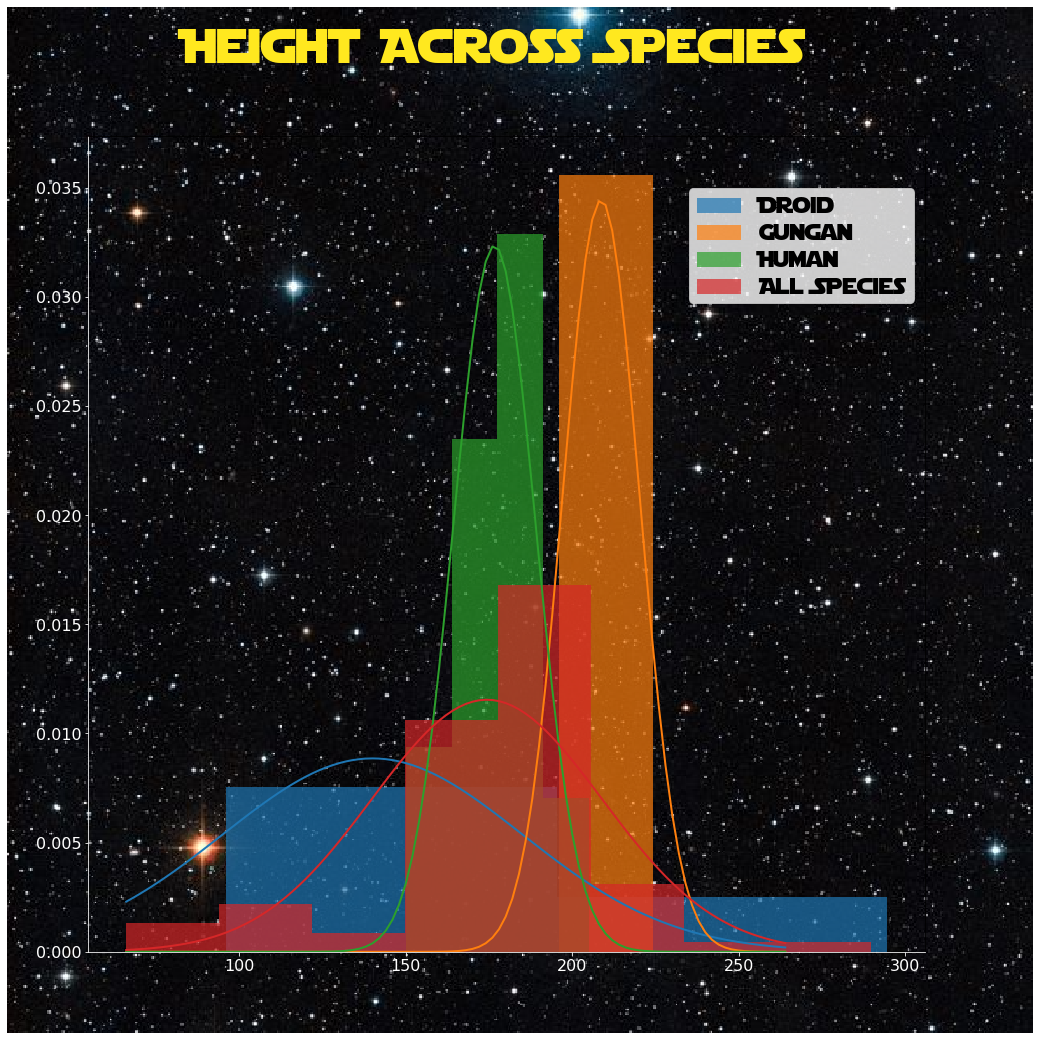

In [34]:
fig,ax = plot_df_hist(df,'species',['Droid', 'Gungan', 'Human','All Species'], plot_type='single', 
                 bin_val='scott',graph_width=15,mt_size=48, main_title='Height Across Species')

In [35]:
logos = ['e1_logo','e2_logo','e3_logo','e4_logo','e5_logo','e6_logo','fa_logo',
         'r1_logo','last_jedi_logo','solo_logo']
posters = ['e1_poster','e2_poster','e3_poster','e4_poster','e5_poster','e6_poster','fa_poster',
           'r1_poster','last_jedi_poster','solo_poster']

# These are the films in the API
Looks like they don't have Rogue One or Solo. Too bad - those were super good.

In [36]:
movie_cols = ['A New Hope','The Empire Strikes Back','Return of the Jedi', 
              'The Phantom Menace','Attack of the Clones', 'Revenge of the Sith', 
              'The Force Awakens']
print(*[i.ljust(30) for i in movie_cols])

A New Hope                     The Empire Strikes Back        Return of the Jedi             The Phantom Menace             Attack of the Clones           Revenge of the Sith            The Force Awakens             


In [37]:
def get_gender_count(s):
    return [np.where(s == i)[0].shape[0] for i in ['male','female','no gender']]

i = movie_cols[0]
movie_mask =df[i]
s = df[movie_mask]['gender']
get_gender_count(s)

[12, 2, 3]

In [38]:
df[['name','gender']][movie_mask][:10]

,name,gender
0,Luke Skywalker,male
1,C-3PO,no gender
2,R2-D2,no gender
3,Darth Vader,male
4,Leia Organa,female
5,Owen Lars,male
6,Beru Whitesun lars,female
7,R5-D4,no gender
8,Biggs Darklighter,male
9,Obi-Wan Kenobi,male


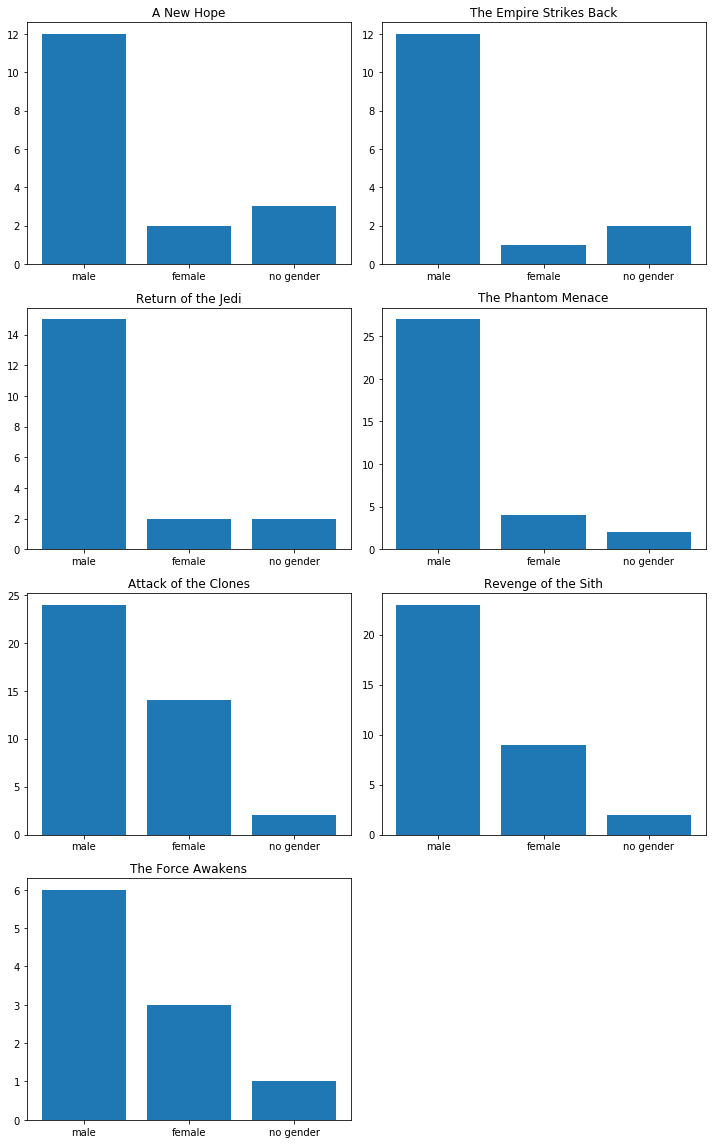

In [39]:
fig = plt.figure(figsize = (10,16))
ax = []
labels = ['male','female','no gender']
no_gender_count = 0
for v, i in enumerate(movie_cols):
    movie_mask =df[i]
    s = df[movie_mask]['gender']
    h = get_gender_count(s)
    ax.append(fig.add_subplot(4,2,v+1))
    ax[-1].bar(np.linspace(1,3,3), h, tick_label=labels)
    ax[-1].set_title(i)
    no_gender_count += h[2]
fig.tight_layout()

In [40]:
import sklearn

# Linear Regression
A lot of people sneer at linear regression because it isn't as shiny as the newer, more complicated models that are available. But linear regression has a lot of advantages, and it's often the best model for a problem.
- It's interpretable - an advantage that many more complicated models, such as neural networks, lack
- It's simple, which means it's easy to get up and running quickly

Linear regression has relatively high bias and low variance, which means that it's a little bit harder to overfit than some more complicated models. There is a limit though - and each variable that we add to our model will make it easier to overfit. It's probably a good idea to use just a few of these columns to fit our model. 

Additionally, we need to put our data into a form that our linear regression can "understand". If we want to use columns that have non-numerical values, first we'll need to transform them into numbers.

In [41]:
df.columns

Index(['name', 'birth_year', 'eye_color', 'gender', 'hair_color', 'height',
       'mass', 'skin_color', 'homeworld', 'species', 'The Empire Strikes Back',
       'Revenge of the Sith', 'Return of the Jedi', 'A New Hope',
       'The Force Awakens', 'X-wing', 'Imperial shuttle', 'Snowspeeder',
       'Imperial Speeder Bike', 'Attack of the Clones', 'The Phantom Menace',
       'TIE Advanced x1', 'Jedi starfighter', 'Trade Federation cruiser',
       'Naboo star skiff', 'Jedi Interceptor', 'Belbullab-22 starfighter',
       'Tribubble bongo', 'Naboo fighter', 'Zephyr-G swoop bike',
       'XJ-6 airspeeder', 'Millennium Falcon', 'AT-ST', 'Slave 1', 'A-wing',
       'Naboo Royal Starship', 'Scimitar', 'Sith speeder', 'Flitknot speeder',
       'Koro-2 Exodrive airspeeder', 'Tsmeu-6 personal wheel bike',
       'T-70 X-wing fighter', 'H-type Nubian yacht'],
      dtype='object')

# Feature Engineering
"birth_year" and "mass" are the only variables that we don't need to transform somehow. 
- eye_color - maybe I'll do "brown or blue" and "other"
- gender - the "Gender Across Films" graph above is a bit deceptive, since the same droids tend to appear across a lot of films. I'll do "male" and "female"
- hair_color - I'll make this "bald" and "not_bald"
- mass - this is fine (target leakage aside)
- skin_color - I'll say that everything that isn't "fair","light","dark" is an unusual skin color
- homeworld - skiping this one
- species - human and other


In [42]:
x_cols = ['birth_year', 'eye_color', 'gender', 'hair_color', 'mass',
          'skin_color', 'homeworld', 'species']
for i in x_cols:
    print_unique_counts(df, i, w=20)
    print('')

birth_year          counts             |birth_year          counts         
------------------------------------------------------------------------
-52.0               counts: 2          |-57.0               counts: 1      
-92.0               counts: 2          |-8.0                counts: 1      
-48.0               counts: 2          |-53.0               counts: 1      
-41.9               counts: 2          |-15.0               counts: 1      
-72.0               counts: 2          |-47.0               counts: 1      
-82.0               counts: 2          |-46.0               counts: 1      
-19.0               counts: 2          |-44.0               counts: 1      
-102.0              counts: 1          |-41.0               counts: 1      
-112.0              counts: 1          |-40.0               counts: 1      
-91.0               counts: 1          |-37.0               counts: 1      
-54.0               counts: 1          |-33.0               counts: 1      
-200.0         

In [43]:
def make_test_frame(df):
    lin_cols = ['height','birth_year','eyes_brown_blue','is_female',
                'is_bald','mass','is_human']
    df_x = pd.DataFrame(columns=lin_cols)
    df_x['height'] = df.height.copy()
    df_x['birth_year'] = df.birth_year.copy()
    df_x['mass'] = df.mass.copy()
    df_x['is_female'] = [i=='female' if i in ['male','female'] \
                         else np.nan for i in df.gender]
    df_x['is_bald'] = [True if i in ['none','no hair'] \
                       else False for i in df.hair_color]
    df_x['unusual_skin_color'] = [True if i not in ['fair','light', 'dark'] \
                                  else False for i in df.skin_color] 
    df_x['is_human'] = [i == 'Human' for i in df.species]
    df_x['eyes_brown_blue'] = [True if i in ['brown','blue'] \
                               else False for i in df.eye_color]
    return df_x

In [44]:
df_x = make_test_frame(df)

In [45]:
df_x.head()

,height,birth_year,eyes_brown_blue,is_female,is_bald,mass,is_human,unusual_skin_color
0,172.0,-19.0,True,False,False,77,True,False
1,167.0,-112.0,False,NaN,True,75,False,True
2,96.0,-33.0,False,NaN,True,32,False,True
3,202.0,-41.9,False,False,True,136,True,True
4,150.0,-19.0,True,True,False,49,True,False


## Run 1
We can't perform a linear regression if we have missing values. There are a lot of ways to handle these - but the simplest is just to drop all the rows with NaNs. We'll try something fancier later if we have time

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
df_x = df_x.dropna()
df_x.head()

,height,birth_year,eyes_brown_blue,is_female,is_bald,mass,is_human,unusual_skin_color
0,172.0,-19.0,True,False,False,77,True,False
3,202.0,-41.9,False,False,True,136,True,True
4,150.0,-19.0,True,True,False,49,True,False
5,178.0,-52.0,True,False,False,120,True,False
6,165.0,-47.0,True,True,False,75,True,False


In [48]:
from sklearn.linear_model import LinearRegression
np.random.seed(1337)    # it's important to set the seed for reproducability 
                        # and to keep from just rerunning with different parameters
                        # until a "good score" is reached
if 'height' in df_x.columns:
    y = df_x.pop('height')
x_train, x_test, y_train, y_test = train_test_split(df_x, y)

In [49]:
reg = LinearRegression().fit(x_train, y_train)

## Run 1 Results

For context, the R^2 score is: 

```(TSS (total sum of squares) - RSS (residual sum of squares)) / TSS```

A model that just guessed the average and disregarded the inputs would have an R^2 of 0, and the best possible model would be an R^2 of 1. A negative number means we're doing worse than if we just guessed the average.

That makes sense when we consider the small sample size. We should see what we can do to drop fewer rows.

In [50]:
reg.score(x_test, y_test), len(x_train), len(x_test)

(-2.256947525171047, 24, 8)

## Run 2

There are 44 entries in the "birth_years" column. By dropping this column we can probably get better results 


In [51]:
df_x = make_test_frame(df)
if 'birth_year' in df_x.columns: df_x = df_x.drop('birth_year',axis=1)
df_x = df_x.dropna()
print(df_x.shape)
df_x.head()

(54, 7)


,height,eyes_brown_blue,is_female,is_bald,mass,is_human,unusual_skin_color
0,172.0,True,False,False,77,True,False
3,202.0,False,False,True,136,True,True
4,150.0,True,True,False,49,True,False
5,178.0,True,False,False,120,True,False
6,165.0,True,True,False,75,True,False


In [52]:
if 'height' in df_x.columns: y = df_x.pop('height')
x_train, x_test, y_train, y_test = train_test_split(df_x, y)

In [53]:
reg = LinearRegression().fit(x_train, y_train)

## Run 2 Results 

This is already a lot better. By getting rid of the troublesome column, we've increased our sample size and improved our score immensely. 

In [54]:
reg.score(x_test, y_test), len(x_train), len(x_test)

(0.7929901233325982, 40, 14)